## Test of Nguyen-Truong formula for excitons
Ref: Nguyen-Truong, PRB 105, L201407 (2022)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import math 
from context import mdirac as md
import importlib
importlib.reload(md)
np.set_printoptions(precision=6)

In [2]:
# Nguyen Fig.1a
epsilon=1.
r0=2.*math.pi*5.25/epsilon
mu=0.19
Delta=20. # eV, large for effective mass approximation
Delta_au=Delta/md.Hartree
vf_au=0.5*math.sqrt(Delta_au/mu)
vf=vf_au*md.Bohr*md.Hartree
Lunit = vf/Delta # Angstrom

In [3]:
r0au=r0/md.Bohr # r0 = r0_Nguyen/epsilon

In [4]:
N1=int(1000)
K1=5.

In [5]:
### Setup mesh
dr=2.*math.pi/K1 
cell=dr*np.array([[1.,0.],[-0.5,0.5*np.sqrt(3)]])
rmesh = md.Parallelogram(N1,cell)
kmesh = rmesh.reciprocal_cell()
kmesh.hexagon = kmesh.get_hexagon(fraction=0.1)

In [6]:
# Parameter to check BSE complexity: < 100 for laptop calculation
math.sqrt(kmesh.hexagon.Np)

85.73797291748855

In [7]:
# Setup interaction
r0eff=r0/Lunit
epseff=epsilon*(Delta/md.Hartree)*(Lunit/md.Bohr)
keld=md.interaction.Keldysh(epseff,r0eff)

In [8]:
### Two types of quadratures for discretizing the potential
#Wk=md.interaction.sample_to_mesh(keld,kmesh)
Wk=md.interaction.sample_to_mesh(keld,rmesh,quadrature='fft') # fraction<=0.1 for convergence

In [9]:
### Display potential for check
#kmesh.show(c=np.log(np.abs(Wk)),dpi=100,s=0.2)

In [10]:
# ### Direct BSE calculation for check (slow)
# %time Wkk=md.interaction.pairs(kmesh.hexagon,Wk)
# E,U=md.eighT(kmesh.hexagon)
# %time H=md.Hbse(E,U,Wkk)
# %time Ex,UxT=np.linalg.eigh(H); Ux=UxT.T
# Delta*Ex[:10]
# kmesh.hexagon.show(c=np.abs(Ux[0]),s=10,cmap='gnuplot')

In [11]:
### Toeplitz matrix BSE calculation for s-states (fast)
#%time H=md.Hbse_toeplitz(kmesh.hexagon,Wk)
%time H=md.Hbse_toeplitz(kmesh.hexagon,Wk,berry=False) ### DEBUG: berry phase off
%time E0x,U0xT=np.linalg.eigh(H); U0x=U0xT.T
Delta*(1.-E0x[:5])

CPU times: user 4.52 s, sys: 23.8 ms, total: 4.54 s
Wall time: 4.54 s
CPU times: user 1.23 s, sys: 60.2 ms, total: 1.29 s
Wall time: 139 ms


array([0.604239, 0.260168, 0.151184, 0.09914 , 0.069896])

In [12]:
Ex=E0x.copy()
Ux=np.empty((Ex.size,kmesh.hexagon.Np),dtype=np.complex128)
for n in range(Ux.shape[0]):
    Ux[n]=kmesh.hexagon.fill_with(U0x[n])

In [13]:
### Exciton radius in k space
q2=np.sum(kmesh.hexagon.p**2,axis=1)
qex=math.sqrt(np.sum(np.abs(Ux[0])**2*q2))
print('qex:',qex)
print('min K1:',5*qex/0.1)

qex: 0.06536787867884405
min K1: 3.268393933942203


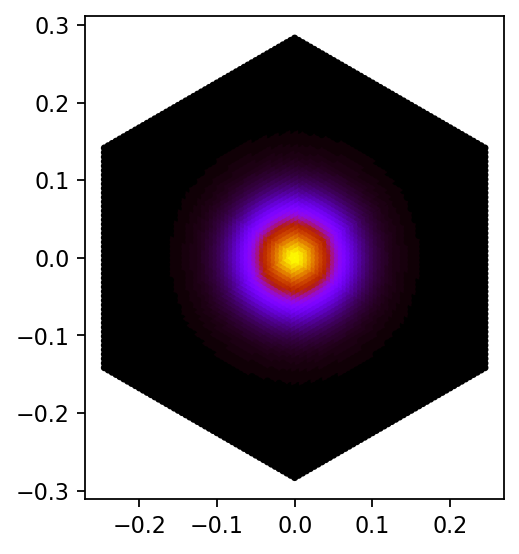

In [14]:
kmesh.hexagon.show(c=np.abs(Ux[0])**2,s=5,cmap='gnuplot')

In [15]:
#E,U=md.eighT(kmesh.hexagon)
E,U=md.eighT(kmesh.hexagon,berry=False) # DEBUG: berry off
dE=E[:,1]-E[:,0]
csxv = md.cov_matrix_elements(md.sx,U); rcv=csxv/dE
xsx0 = md.exciton_elements(Ux,csxv); rx0=xsx0/Ex

In [16]:
def Enguyen(n0):
    n=1+n0
    sq = math.sqrt(0.4*mu*r0au/epsilon) # epsilon^1 because of r0au
    bracket = np.sqrt(n-0.5+2.0*sq) - np.sqrt(n-0.5)
    En=25.*bracket**4/(8.*mu*r0au*r0au)
    return En*md.Hartree # eV

In [17]:
# Nguyen formula modified by replacament mu->5*mu/4
def Enguyen_mod(n0):
    n=1+n0
    sq = math.sqrt(2*mu*r0au/epsilon) # epsilon^1 because of r0au
    bracket = np.sqrt(n-0.5+sq) - np.sqrt(n-0.5)
    En=5.*bracket**4/(2.*mu*r0au*r0au)
    return En*md.Hartree # eV

Text(0.5, 0, '$E_b,\\rm eV$')

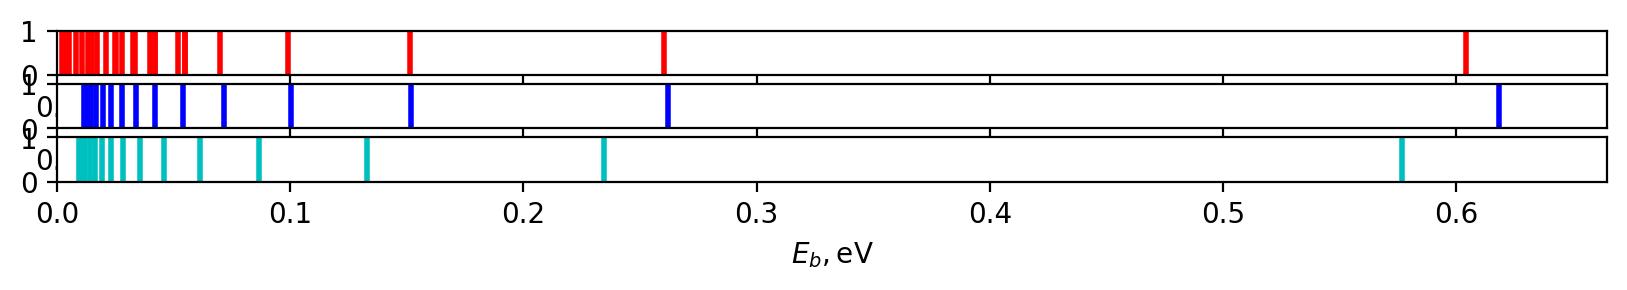

In [20]:
fig,ax=plt.subplots(3,1,dpi=100,figsize=(10,1))
inds,=np.where(Ex<1)
for n in range(30):    
    ax[0].axvline(x=Delta*(1.-Ex[n]),c='r',ls='solid',lw=2) 
for n in range(15):    
    ax[1].axvline(x=Enguyen_mod(n),c='b',ls='solid',lw=2) 
for n in range(15):    
    ax[2].axvline(x=Enguyen(n),c='c',ls='solid',lw=2)
ebmax=max(Delta*(1.-Ex[0]),Enguyen(0))
for i in range(3):
    ax[i].set_xlim([0.,1.1*ebmax])    
ax[2].set_xlabel(r'$E_b,\rm eV$')    